In [1]:
# !pip install tensorflow gym keras-rl gym[atari]
!pip install tensorflow gym keras-rl 'gym[atari]' 'gym[accept-rom-license]' opencv-python
# !pip install opencv-python

ERROR: Invalid requirement: "'gym[atari]'"


In [2]:
#necessary imports
import gym 
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import cv2

Pre-proccessing 

In [127]:
#function that takes a frame from the game, crops it to 84X84, and puts it in
# gray scale, used to reduce dimensionality and speed up learning
def resize_frame(frame):
    frame = np.average(frame,axis = 2)
    frame = frame[30:-5,:]
    frame = cv2.resize(frame,(84,84),interpolation = cv2.INTER_NEAREST)
    frame = np.array(frame,dtype = np.uint8)
    frame = np.expand_dims(frame, axis=-1)
    frame = np.repeat(frame, 3, axis=-1)
    return frame

Class For Memory Buffer

In [172]:
#class for storing experiences of the agent. Has a fixed size that when it
#reaches the end of, it overwrites what was at the start
class Memory(object):
    def __init__(self, input_shape, buffer_size, batch_size):
        self.states = np.zeros((buffer_size,) + input_shape)
        self.next_states = np.zeros((buffer_size,) + input_shape)
        self.actions = np.zeros(buffer_size, dtype=np.uint8)
        self.rewards = np.zeros(buffer_size)
        self.terminal = np.zeros(buffer_size)
        self.buffer_index = 0
        self.buffer_size = buffer_size
        self.batch_size = batch_size

    #space the state, action, reward, next state, and state of episode in the
    #replay memory. Cap the length of memory at buffer size (init parameter), 
    #and overwrite oldest memory when buffer filled
    def save_action(self, state, action, reward, next_state, done):
        self.states[self.buffer_index] = state
        self.next_states[self.buffer_index] = next_state
        self.actions[self.buffer_index] = action
        self.rewards[self.buffer_index] = reward
        self.terminal[self.buffer_index] = 1 - int(done)
        #move up the index of where to write in fized memory, and reset if
        #max size is reached
        self.buffer_index = (self.buffer_index + 1) % self.buffer_size

    # return info from n randomly selected experiences, where in the the batch
    #size specified in initialzation
    def sample_memory(self):
        indicies = np.random.randint(0, self.buffer_index, self.batch_size)
        return self.states[indicies], self.actions[indicies], self.rewards[indicies], self.next_states[indicies], self.terminal[indicies]
    



Function For Deep Q Network

In [173]:
#from https://keras.io/examples/rl/deep_q_network_breakout/, function that
#initializes deep q network
def init_deep_q_network(input_shape, num_actions):
    # Network defined by the Deepmind paper
    inputs = layers.Input(shape=input_shape)

    # Convolutions on the frames on the screen
    layer1 = layers.Conv2D(32, 8, strides=4, activation="relu")(inputs)
    layer2 = layers.Conv2D(64, 4, strides=2, activation="relu")(layer1)
    layer3 = layers.Conv2D(64, 3, strides=1, activation="relu")(layer2)

    layer4 = layers.Flatten()(layer3)

    layer5 = layers.Dense(512, activation="relu")(layer4)
    action = layers.Dense(num_actions, activation="linear")(layer5)

    return keras.Model(inputs=inputs, outputs=action)

Class For Learning Agent

In [269]:
#class that performs the actions of agent in a learning environment, namely 
#action selection and Q function learning. This agent is set up with an 
#attention module consisting of an aditional set of q networks. It still has 
#the same q-network for learning atari game actions, but it has an additional
#network (with the same architecutre save for the output shape), that learns
#"attentional movement" actions. Rather than perform a naive dimensionality
#reduction to lower the input to the second network, dimensionality is reduced
#by restricting input to the game action learning agent to a window of the
#screen. The agent can move the center point of this window, and learns both
#where it should set this focal point, as well as what actions it should take
#given what it is paying attention to
class Agent(object):
    def __init__(self, alpha, gamma, actions_amt, epsilon, input_shape, input_shape_attention=(84, 84, 3), epsilon_dec=0.996, epsilon_end=0.01, batch_size=64, fname='dqn_model.h5', buffer_size=1000, window_x=84, window_y=84, x_max=160, y_max=210):
        self.alpha = alpha
        self.gamma = gamma
        self.actions_amt = actions_amt
        self.epsilon = epsilon 
        self.input_shape = input_shape
        self.input_shape_attention = input_shape
        self.epsilon_dec = epsilon_dec
        self.epsilon_end = epsilon_end
        self.fname = fname
        self.q_network = init_deep_q_network(input_shape, alpha, actions_amt, 256, 256)
        self.q_network_target = init_deep_q_network(input_shape, alpha, actions_amt, 256, 256)
        self.attention_q = init_deep_q_network(input_shape_attention, alpha, actions_amt, 256, 256)
        self.attention_q_target = init_deep_q_network(input_shape_attention, alpha, actions_amt, 256, 256)
        self.memory = Memory(input_shape, actions_amt, buffer_size, batch_size)
        self.loss_function = keras.losses.Huber()
        self.optimizer = keras.optimizers.legacy.Adam(learning_rate=0.00025, clipnorm=1.0)
        self.model_file = "rl_agent"
        self.attention_model_file = "attention_network"
        self.window_x = window_x
        self.window_y = window_y
        self.x_max = x_max
        self.y_max = y_max

    #any method with actor=True as a default parameter pertain to actions that
    #could be done on the behavioral (game action) q_network, or the attention
    #location learning network. Actor=True means that the selected network is
    #the behavioral
    
    
    def select_action(self, input, actor=True): 
        if actor:
            network = self.q_network
            num_actions = self.actions_amt
        else: 
            network = self.attention_q
            num_actions = 5
        
        #epsilon greedy action selection 
        if np.random.rand() > self.epsilon:
            action_values = network.predict(input[None,...], verbose=0)
            action = np.argmax(action_values)
        else:
            action = np.random.choice(num_actions)
        
        return action 
    
    def store_action(self, state, action, reward, next_state, done, actor=True):
        self.memory.save_action(state, action, reward, next_state, done)

    #gradient tape section also taken from 
    #https://keras.io/examples/rl/deep_q_network_breakout/
    def learn(self, actor=True):
        if actor:
            network = self.q_network
            target_network = self.q_network_target
        else: 
            network = self.attention_q
            target_network = self.attention_q_target
        
        #get information from randomly selected experiences in replay memory
        states, actions, rewards, new_states, dones = self.memory.sample_memory()
        states = tf.stack(states)
        actions = tf.stack(actions)
        new_states = tf.stack(new_states)
        dones = tf.stack(dones)
        new_states = tf.stack(new_states)
        
        #calculate updates
        future_rewards = target_network.predict(new_states, verbose=0)
        updated_qs = rewards + self.gamma * tf.reduce_max(future_rewards, axis=1)
        masks = tf.one_hot(actions, self.actions_amt)
        
        #backpropogate 
        with tf.GradientTape() as tape:
            q_values = network(states)
            q_actions = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)
            loss = self.loss_function(updated_qs, q_actions)
        grads = tape.gradient(loss, network.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, network.trainable_variables))
        target_network.set_weights(network.get_weights())
        
        #decrement epsilon if it is not at its minimal value
        if self.epsilon > self.epsilon_end:
            self.epsilon -= self.epsilon_dec

    #set the starting focal point (center of attention rectangle) to be 
    #centered at the bottom of the frame
    def set_focal_point(self):
        y = self.y_max
        x = self.x_max
        x_init = x / 2
        y_init = y - (self.window_y / 2)
        self.focal_point = (x_init, y_init)

    #move the frame based on action selected from agent, unless movement would
    #place any part of the attentional rectangle out of bounds
    def move_focal_point(self, action, stride=5):
        x,y = self.focal_point
        if (action == 0) and (x - stride - (self.window_x / 2) > 0):
            x = x - stride
        if (action == 1) and (x + stride + (self.window_x / 2) < self.x_max):
            x = x + stride
        if (action == 2) and (y - stride - (self.window_y / 2) > 0):
            y = y - stride
        if (action == 3) and (y + stride + (self.window_y / 2) < self.y_max):
            y = y + stride
        self.focal_point = (x,y)
    
    #extract from the entire frame given by the environment on the rectangle
    #defined by the focal point for the attention, and the size of the 
    #attentional rectangle 
    def extract_frame(self, input):
        focal_point = self.focal_point
        x_len, y_len = self.window_x, self.window_y
        x,y = focal_point
        x_half = x_len / 2
        y_half = y_len /2
        
        x_left = x - x_half
        x_right = x + x_half
        y_up = y + y_half
        y_down = y - y_half
        
        x_left = int(x_left)
        x_right = int(x_right)
        y_up = int(y_up)
        y_down = int(y_down)
        
        frame = input[y_down:y_up, x_left:x_right]
        return frame
    
    def save_model(self, actor=True):
        if actor:
            network = self.q_network
            file = self.model_file
        else: 
            network = self.attention_q
            file = self.attention_model_file
        
        network.save(file)

    def load_model(self):
        self.q_network = load_model(self.model_file)
        

        

Run Learning Loop

In [286]:
import matplotlib.pyplot as plt
#specify learning environment
env = gym.make('Breakout-v4', render_mode="human")
#number of games agent will play
n_games = 150001
agent = Agent(gamma=.99, epsilon=.5, alpha=.0005, actions_amt=4, input_shape=(84, 84, 3), batch_size=32, epsilon_end=0.01, buffer_size=1000, epsilon_dec=.01, window_x=84, window_y=84)
agent.set_focal_point()
scores = []
eps_history = []
frames = []
focal_points = []

for i in range(n_games):
    done = False
    score = 0
    observation = env.reset()
    observation = observation[0]
    first_observation = observation
    first_focal_point = agent.focal_point
    focal_points.append(first_focal_point)
    frames.append(first_observation)
    observation = agent.extract_frame(observation)
    
    print(np.shape(observation))
    #iterator for learning schedule
    j = 0
    #loop until current game is terminated
    while not done: 
        env.render()
        #select game action and attention movement action
        action = agent.select_action(observation)
        fp_action = agent.select_action(observation, actor=False)
        agent.move_focal_point(fp_action)
        
        #get information from environment
        observation_raw, reward, done, truncated, info = env.step(action)
        focal_points.append(agent.focal_point)
        frames.append(observation_raw)
        observation_ = agent.extract_frame(observation_raw)
        
        #update running score
        score += reward
        
        #save experience to replay memory for acting and attention agent
        agent.store_action(observation, action, reward, observation_, done)
        agent.store_action(observation, action, reward, observation_, done, actor=False)
        observation = observation_

    #learn control for game actions and attention location
    agent.learn()
    agent.learn(actor=False)
    eps_history.append(agent.epsilon)
    scores.append(score)

    avg_score = np.mean(scores[max(0, 1 - 100):(i + 1)])
    #if i % 10 == 0:
    print("episode ", i, "score %.2f" % score, 'average score %.2f' % avg_score)

    #if i % 10 == 0 and i > 0: 
        #agent.save_model()

(84, 84, 3)
episode  0 score 0.00 average score 0.00
(84, 84, 3)
episode  1 score 0.00 average score 0.00
(84, 84, 3)
episode  2 score 2.00 average score 0.67
(84, 84, 3)
episode  3 score 3.00 average score 1.25
(84, 84, 3)
episode  4 score 0.00 average score 1.00
(84, 84, 3)
episode  5 score 2.00 average score 1.17
(84, 84, 3)
episode  6 score 1.00 average score 1.14
(84, 84, 3)
episode  7 score 2.00 average score 1.25
(84, 84, 3)
episode  8 score 2.00 average score 1.33
(84, 84, 3)
episode  9 score 2.00 average score 1.40
(84, 84, 3)
episode  10 score 2.00 average score 1.45
(84, 84, 3)
episode  11 score 1.00 average score 1.42
(84, 84, 3)
episode  12 score 3.00 average score 1.54
(84, 84, 3)
episode  13 score 0.00 average score 1.43
(84, 84, 3)
episode  14 score 0.00 average score 1.33
(84, 84, 3)


: 

(3, 205) (87, 121)


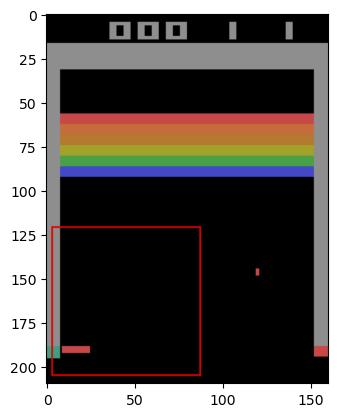

In [266]:
def show_focus(focal_point, frame):
    x,y= focal_point
    width = agent.window_x
    height = agent.window_y
    top_left = (int(x - width/2), int(y + height/2))
    bottom_right = (int(x + width/2), int(y - height/2))
    print(top_left, bottom_right)
    image = cv2.rectangle(frame, top_left, bottom_right, (225,0,0), 1)
    plt.imshow(image)


show_focus(focal_points[150], frames[150])

1.5416666666666667


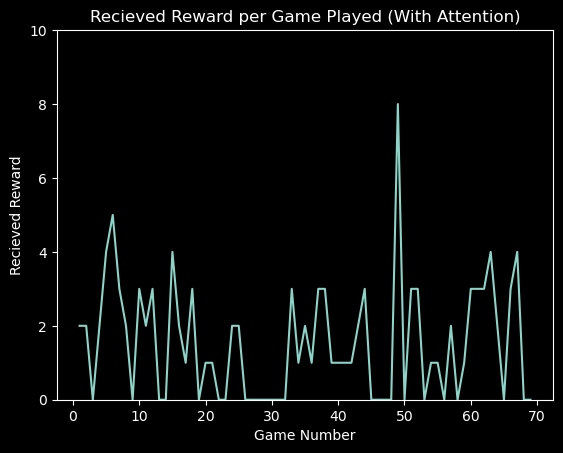

In [280]:

avg_score = np.mean(scores[max(0, 1 - 100):(i + 1)])
print(avg_score)
plt.style.use('dark_background')
def plot_line_chart(scores):
   # Generate x-axis values (assuming scores are evenly spaced)
   x_values = range(1, len(scores) + 1)


   # Plot the line chart
   plt.plot(x_values, scores, linestyle='-')


   # Add labels and title
   plt.xlabel('Game Number')
   plt.ylabel('Recieved Reward')
   plt.title('Recieved Reward per Game Played (With Attention)')
   ax = plt.gca()
   ax.set_ylim([0,10])

   # Display the chart
   plt.show()




plot_line_chart(scores[0:69])